# Retail Rocket
The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (itemproperties.сsv) and a file, which describes category tree (categorytree.сsv). The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues.

The behaviour data, i.e. events like clicks, add to carts, transactions, represent interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely “view”, “addtocart” or “transaction”. In total there are 2 756 101 events including 2 664 312 views, 69 332 add to carts and 22 457 transactions produced by 1 407 580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

Took direct from [paperswithcode](https://paperswithcode.com/dataset/retailrocket) and [Kaggle](https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset)

in this case im using only the interaction dataset (events.csv)

## Task 
Task: Predict the next product.

In this case, I'm trying to predict the next item in the session without distinguishing between the event types. Even though I split the sequences by user, and this could be a user-item problem, I solve it as an item-item problem. Given a sequence of products, I predict the next product in the session.

## Solution
To solve this task I develop a retrieval models using Two-Tower architecture:
A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
A candidate model computing the candidate representation (an equally-sized vector) using the candidate features
The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

Within the framework of the Two-Tower architecture, this project specifically employs the query tower, utilizing a GRU layer to adeptly encode the sequence of historical products. The GRU's inherent ability to capture temporal dependencies proves invaluable in understanding the sequential nature of user interactions with products over time. Simultaneously, the candidate tower remains unchanged, consistently providing a robust representation of candidate products.

Reference: 
- [GRU4Rec paper](https://arxiv.org/abs/1511.06939)
- [TensorFlow Recommenders Framework](https://www.tensorflow.org/recommenders/)


## Data Cleaning 
1. Remove items that occur consecutively in the sequence.
2. Exclude users with minimal and excessively extensive activities.
3. Fix columns name.

## Data Preprocessing
1. Group by user.
2. create a sequences with length of n: [1,2,3,4,5,6,7,8] ---> [[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7], [4,5,6,7,8]]
3. Make the last observation (product) in each sequence as target: seq:[3,4,5,6,7] target:[8] 
4. convert the DataFrame into Tensor Dataset.
5. Split the dataset to train validation and test (70%, 15%, 15%).

## Model Training
Training the model with: 
- window_size: 6
- embedding size: 256 
- batch size: 256
- dropout: 0.25
- learning rate: 0.06258085768442055

## Evaluation
1. Prediction example.
2. Evaluation with relevant metrics.
    - Recall@20 at 20: 0.3
    - MMR@20: 0.17        
    - NDCG@20 at 20: 0.3

    

## The Whole Process With Hyper Parameter Tuning
The whole process in one piece of code including hyper parameter tuning.

## Import Libraries

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Union
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna

## Helper Functions

In [ ]:
def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0

    while start_index + window_size <= len(values):
        seq = values[start_index:start_index + window_size]
        sequences.append(seq)
        start_index += step_size

    # Padding for sequences with less than window_size
    if start_index < len(values):
        remaining = window_size - (len(values) - start_index)
        padded_seq =  [0] * remaining + values[start_index:]
        sequences.append(padded_seq)

    return sequences

def train_validation_test_split(map_tf_df: tf.data.Dataset,
                                data_len: int,
                                validation_share: float,
                                test_share: float) -> tuple:
    """
    Split a TensorFlow dataset into train, validation, and test sets.

    Args:
        map_tf_df (tf.data.Dataset): The dataset to split.
        data_len (int): The total length of the dataset.
        validation_share (float): The proportion of the data to allocate to the validation set (0.0 to 1.0).
        test_share (float): The proportion of the data to allocate to the test set (0.0 to 1.0).

    Returns:
        tuple: A tuple containing three datasets (train, validation, test).

    """
    # Shuffle the dataset
    shuffled = map_tf_df.shuffle(100_000, seed=1234, reshuffle_each_iteration=False)

    # Calculate sizes for each set
    train_size = int((1 - validation_share - test_share) * data_len)
    validation_size = int(validation_share * data_len)
    test_size = int(test_share * data_len)

    # Create train, validation, and test sets
    train = shuffled.take(train_size)
    validation = shuffled.skip(train_size).take(validation_size)
    test = shuffled.skip(train_size + validation_size).take(test_size)

    # Batch and cache the datasets
    cached_train = train.batch(4096).cache()
    cached_validation = validation.batch(4096).cache()
    cached_test = test.batch(4096).cache()

    return cached_train, cached_validation, cached_test



def accuracy_at_k_recommendations_np(predictions, true_labels, k):
    """
    Calculate accuracy at k for recommendation lists using NumPy arrays.

    Parameters:
    - predictions: NumPy array containing recommended items for each user.
    - true_labels: NumPy array containing true items for each user.
    - k: The value of k for accuracy calculation.

    Returns:
    - accuracy: The accuracy at k for recommendation lists.
    """
    correct_count = 0

    for i in range(predictions.shape[0]):
        # Take the top-k recommended items
        top_k_recommendations = predictions[i, :k]

        # Check if any true label is among the top-k recommendations
        if np.any(np.isin(true_labels[i], top_k_recommendations)):
            correct_count += 1

    # Calculate accuracy at k
    accuracy = correct_count / predictions.shape[0]
    return accuracy


def recall_at_k(predictions: np.array, targets: np.array, k: int) -> float:
    """
    Calculate Recall@k.

    Parameters:
    - predictions: 2D NumPy array, where each row represents the ranked list of relevance scores.
                   The first element in each row is considered the most relevant.
    - targets: 2D NumPy array, where each row represents the ground truth relevance scores.
               It should have the same structure as the predictions.
    - k: Integer, the cutoff rank for evaluation.

    Returns:
    - recall: Float, the Recall@k.
    """
    top_k_predictions = predictions[:, :k]
    recall = np.mean([np.isin(target, top_k_predictions[i, :]) for i, target in enumerate(targets)])
    return recall


def mrr_at_k(predictions: np.array, targets: np.array, k: int) -> float:
    """
    Calculate MRR@k.

    Parameters:
    - predictions: 2D NumPy array, where each row represents the ranked list of relevance scores.
                   The first element in each row is considered the most relevant.
    - targets: 2D NumPy array, where each row represents the ground truth relevance scores.
               It should have the same structure as the predictions.
    - k: Integer, the cutoff rank for evaluation.

    Returns:
    - mrr: Float, the MRR@k.
    """
    rr = []
    for pred, target in zip(predictions[:, :k], targets):
        if target in pred:
            rr.append((1/(np.where(pred == target)[0][0]+1)))
        else:
            rr.append(0)
    return np.mean(rr)


def ndcg_at_k(predicted_ranking, actual_ranking, k):
    """
    Calculate Normalized Discounted Cumulative Gain at k.

    Parameters:
    - actual_ranking: List of true rankings (ground truth).
    - predicted_ranking: List of predicted rankings.
    - k: The position to consider in the rankings.

    Returns:
    - NDCG@k score.
    """
    if len(actual_ranking) != len(predicted_ranking):
        raise ValueError("Length of actual and predicted rankings must be the same.")

    dcg = 0.0
    idcg = 0.0

    for i in range(len(actual_ranking)):
        actual_rank = actual_ranking[i]
        predicted_rank = predicted_ranking[i][:k]

        # Calculate DCG (Discounted Cumulative Gain)
        gain = 2 ** 1 - 1 if actual_rank in predicted_rank else 0
        dcg += gain / np.log2(i + 2)

        # Calculate ideal DCG for normalization
        gain_idcg = 2 ** 1 - 1
        idcg += gain_idcg / np.log2(i + 2)

    # Avoid division by zero
    if idcg == 0:
        return 0.0

    # Calculate NDCG@k
    ndcg = dcg / idcg
    return ndcg


class GRU4REC(tfrs.Model):
    """
    2 Towers model using GRU for sequential recommendations system.
    For more details: https://www.tensorflow.org/recommenders/examples/sequential_retrieval

    Attributes:
        embedding_dimension (int): Embedding size for all the models (query and candidate).
        items (tf.data.Dataset): MapDataset of all the items_ids.
        add_layer (bool): Whether to add another GRU layer.
        dropout (float): Dropout rate for GRU layers.
        recurrent_dropout (float): Recurrent dropout rate for GRU layers.

    Returns:
        tf.keras.Model: A 2 Towers model using GRU for sequential recommendations.
    """
    def __init__(self, embedding_dimension: int, items: tf.data.Dataset, add_layer: bool = False, dropout: float = 0.2, recurrent_dropout: float = 0.2):
        super().__init__()

        """
        Parameters
        -----------
        embedding_dimension : int
            Embedding size for all the models (query and candidate).
        items : tf.data.Dataset
            MapDataset of all the items_ids.
        add_layer : bool
            Whether to add another GRU layer.
        dropout : float
            Dropout rate for GRU layers.
        recurrent_dropout : float
            Recurrent dropout rate for GRU layers.

        Return
        -------
        tf.keras.Model
        """
        self.items = items
        items_ids = self.items.batch(1_000)
        self.unique_items_ids = np.unique(np.concatenate(list(items_ids)))
        self.embedding_dimension = embedding_dimension
        self.dropout=dropout
        self.recurrent_dropout=recurrent_dropout

        if add_layer:
            self._query_model = tf.keras.Sequential([
                tf.keras.layers.StringLookup(
                    vocabulary=self.unique_items_ids, mask_token=None),
                tf.keras.layers.Embedding(len(self.unique_items_ids) + 1, self.embedding_dimension),

                tf.keras.layers.GRU(self.embedding_dimension, return_sequences=True, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout),
                tf.keras.layers.GRU(self.embedding_dimension, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout),
            ])
        else:
            self._query_model = tf.keras.Sequential([
                tf.keras.layers.StringLookup(
                    vocabulary=self.unique_items_ids, mask_token=None),
                tf.keras.layers.Embedding(len(self.unique_items_ids) + 1, self.embedding_dimension),

                tf.keras.layers.GRU(self.embedding_dimension, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout),
            ])

        self._candidate_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=self.unique_items_ids, mask_token=None),
            tf.keras.layers.Embedding(len(self.unique_items_ids) + 1, self.embedding_dimension)
        ])
        
        self._task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
                                            ks=[1, 5, 20, 50, 100], 
                                            candidates=self.items.batch(128).map(self._candidate_model)
                                            )
                                         )

    def compute_loss(self, features: dict, training: bool = False) -> Union[float, tf.Tensor]:
        """
        Compute the loss for the model.

        Parameters:
            features (dict): Dictionary containing input features.
            training (bool): Flag indicating whether the model is in training mode.

        Returns:
            Union[float, tf.Tensor]: Loss value.
        """
        watch_history = features["item_id"]
        watch_next_label = features["target"]

        query_embedding = self._query_model(watch_history)
        candidate_embedding = self._candidate_model(watch_next_label)

        return self._task(query_embedding, candidate_embedding, compute_metrics=not training)

## Data Cleaning 

In [3]:
# Retailrocket
df = (pd
        .read_csv(r'retailrocket_data\events.csv')
        .pipe(lambda df: df.assign(timestamp = pd.to_datetime(df['timestamp'] * 1000000)))
        .sort_values(['visitorid', 'timestamp'])
        .set_index(['visitorid', 'timestamp'])
        .pipe(lambda df: df.assign(itemid_shift = df.groupby(level=0, as_index=False)['itemid'].shift()))
        .reset_index()    
         # drop duplicates and videos with 0 watch duration
        .query("itemid_shift != itemid")
      )

counts = df.visitorid.value_counts()
max_limit = counts[counts<500].index.to_list()
min_limit = counts[counts>5].index.to_list()

df = (df
        .query('visitorid in @min_limit and visitorid in @max_limit')
        .rename(columns={'visitorid':'clientid', 'itemid':'item_id'})
        .astype(str)
      )[['clientid', 'item_id']]

df.head()

,clientid,item_id
4,2,325215
6,2,259884
7,2,216305
8,2,342816
10,2,216305


## Data Preprocessing

In [4]:
# group by user
df_group = df.groupby("clientid")

data = pd.DataFrame(
                     data={
                           "clientid": list(df_group.groups.keys()),
                           "item_id": list(df_group.item_id.apply(list)),
                           }
                    )
data.head()

,clientid,item_id
0,10000,"[359491, 401285, 359491, 401285, 359491, 401285]"
1,100009,"[141157, 9492, 176488, 141157, 9492, 141157, 4..."
2,1000093,"[199101, 346501, 199101, 286219, 304028, 17231..."
3,1000147,"[64253, 373472, 427744, 64253, 427744, 421062,..."
4,1000163,"[20710, 440220, 20710, 358854, 418941, 37184, ..."


In [5]:
# create a sequences with length of n for each user
# [1,2,3,4,5,6,7,8] ---> [[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7], [4,5,6,7,8]]
sequence_length = 6
step_size = 1
data.item_id = data.item_id.apply(lambda ids: create_sequences(ids, sequence_length, step_size))
data.head()['item_id'].values

array([list([['359491', '401285', '359491', '401285', '359491', '401285'], [0, '401285', '359491', '401285', '359491', '401285']]),
       list([['141157', '9492', '176488', '141157', '9492', '141157'], ['9492', '176488', '141157', '9492', '141157', '412813'], ['176488', '141157', '9492', '141157', '412813', '223829'], [0, '141157', '9492', '141157', '412813', '223829']]),
       list([['199101', '346501', '199101', '286219', '304028', '172313'], ['346501', '199101', '286219', '304028', '172313', '346501'], ['199101', '286219', '304028', '172313', '346501', '199101'], ['286219', '304028', '172313', '346501', '199101', '192353'], ['304028', '172313', '346501', '199101', '192353', '119825'], ['172313', '346501', '199101', '192353', '119825', '346501'], ['346501', '199101', '192353', '119825', '346501', '199101'], [0, '199101', '192353', '119825', '346501', '199101']]),
       list([['64253', '373472', '427744', '64253', '427744', '421062'], ['373472', '427744', '64253', '427744', '421062

In [6]:
# explode
# [[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7], [4,5,6,7,8]] --->
#
#0: [1,2,3,4,5]
#0: [2,3,4,5,6]
#0: [3,4,5,6,7]
#0: [4,5,6,7,8]
data_transformed = data[["clientid", "item_id"]].explode(["item_id"], ignore_index=True)
data_transformed.head()

,clientid,item_id
0,10000,"[359491, 401285, 359491, 401285, 359491, 401285]"
1,10000,"[0, 401285, 359491, 401285, 359491, 401285]"
2,100009,"[141157, 9492, 176488, 141157, 9492, 141157]"
3,100009,"[9492, 176488, 141157, 9492, 141157, 412813]"
4,100009,"[176488, 141157, 9492, 141157, 412813, 223829]"


In [7]:
# target is the last records (item) in the list  -> item seq:[4,5,6,7,8] item target:[9]
# convert each variable to numpy array
data_transformed['target'] = data_transformed['item_id'].apply(lambda x : np.array(x[-1], dtype=str))
data_transformed['item_id'] = data_transformed['item_id'].apply(lambda x : np.array(x[:-1], dtype=str))
data_transformed = data_transformed[['item_id', 'target']]

data_transformed.head()

,item_id,target
0,"[359491, 401285, 359491, 401285, 359491]",401285
1,"[0, 401285, 359491, 401285, 359491]",401285
2,"[141157, 9492, 176488, 141157, 9492]",141157
3,"[9492, 176488, 141157, 9492, 141157]",412813
4,"[176488, 141157, 9492, 141157, 412813]",223829


In [8]:
# convert each variable to tensor and store in a dict then convert to tensorflow Dataset
data_transformed = {
                    'item_id': tf.constant(data_transformed["item_id"].to_list(), name='item_id'),
                    'target': tf.constant(data_transformed["target"], name='target')
                   }

tf_dict = tf.data.Dataset.from_tensor_slices(data_transformed)

# map rows to a dictionary
data = tf_dict.map(lambda x: {
                               "item_id": x["item_id"],
                               "target": x["target"]
                             }
                      )

items = tf.data.Dataset.from_tensor_slices({'item_id':df.item_id.unique()}).map(lambda x: x["item_id"])

data

<_MapDataset element_spec={'item_id': TensorSpec(shape=(5,), dtype=tf.string, name=None), 'target': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [9]:
next(data.take(1).as_numpy_iterator())

{'item_id': array([b'359491', b'401285', b'359491', b'401285', b'359491'],
       dtype=object),
 'target': b'401285'}

In [10]:
# Split the dataset to train validation and test
cached_train, cached_validation, cached_test = train_validation_test_split(data, len(data_transformed['target']), 0.15, 0.15)

## Model Training

In [11]:
%%time
# Train The model
model = GRU4REC(embedding_dimension=256,
                items=items,
                add_layer=False,
                dropout=0.25,
                recurrent_dropout=0.25)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.06258085768442055))

# Callbacks setting
es = EarlyStopping(monitor='val_factorized_top_k/top_20_categorical_accuracy', min_delta=0.01, patience=3, verbose=1)
mcp = ModelCheckpoint(filepath=r'gru_weights/weights{epoch:02d}.h5', monitor='val_factorized_top_k/top_20_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
rlr = ReduceLROnPlateau(monitor='val_factorized_top_k/top_20_categorical_accuracy', factor=0.5, patience=1, min_lr=1e-7, verbose=1)

history = model.fit(cached_train, batch_size=256,
                    epochs=50,
                    validation_data=cached_validation, 
                    callbacks=[es, mcp, rlr],
                    verbose=1)

# Save and load the best model
list_of_files = glob.glob('gru_weights/*')
latest_file = max(list_of_files, key=os.path.getctime)

model.built = True
model.load_weights(latest_file)

for f in list_of_files:
    os.remove(f)



Epoch 1/50
58/58 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_20_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 31644.7112 - regularization_loss: 0.0000e+00 - total_loss: 31644.7112
Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.12363, saving model to gru_weights\weights01.h5
58/58 [==============================] - 320s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_20_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 31552.5957 - regularization_loss: 0.0000e+00 - total_loss: 31552.5957 - val_fact

Epoch 7/50
58/58 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_20_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1650.0581 - regularization_loss: 0.0000e+00 - total_loss: 1650.0581
Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.29637 to 0.29684, saving model to gru_weights\weights07.h5
58/58 [==============================] - 350s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_20_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1645.0941 - regularization_loss: 0.0000e+00 - total_loss: 1645.0941 - val_factori

## Evaluation

Now that we have a model, we would like to be able to make predictions. \
We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [12]:
index = tfrs.layers.factorized_top_k.BruteForce(model._query_model, 50)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((items.batch(100), items.batch(100).map(model._candidate_model)))
)

### Prediction Example 

In [13]:
np.expand_dims(next(cached_test.as_numpy_iterator())['item_id'][42], axis=0)

array([[b'167039', b'133169', b'252991', b'167039', b'133505']],
      dtype=object)

In [15]:
_, rec = index(np.expand_dims(next(cached_test.as_numpy_iterator())['item_id'][42], axis=0))

In [16]:
rec

<tf.Tensor: shape=(1, 50), dtype=string, numpy=
array([[b'164324', b'358962', b'167039', b'161780', b'147087', b'254118',
        b'169959', b'72014', b'252991', b'441064', b'170680', b'328541',
        b'5400', b'377140', b'153447', b'213280', b'466710', b'288174',
        b'417464', b'113233', b'180458', b'462226', b'131868', b'213829',
        b'401118', b'8426', b'105869', b'344592', b'187511', b'432842',
        b'5885', b'355553', b'279271', b'309787', b'331514', b'62800',
        b'150258', b'406601', b'92509', b'220286', b'211753', b'48747',
        b'334476', b'165477', b'321585', b'262537', b'449897', b'97577',
        b'435915', b'342938']], dtype=object)>

### Model Evaluation

In [17]:
model.evaluate(cached_train)

58/58 [==============================] - 1119s 19s/step - factorized_top_k/top_1_categorical_accuracy: 0.5208 - factorized_top_k/top_5_categorical_accuracy: 0.9894 - factorized_top_k/top_20_categorical_accuracy: 0.9986 - factorized_top_k/top_50_categorical_accuracy: 0.9996 - factorized_top_k/top_100_categorical_accuracy: 0.9998 - loss: 1051.3123 - regularization_loss: 0.0000e+00 - total_loss: 1051.3123


[0.520810067653656,
 0.9893979430198669,
 0.9985841512680054,
 0.9995659589767456,
 0.9998019337654114,
 871.2779541015625,
 0,
 871.2779541015625]

In [18]:
model.evaluate(cached_validation)

13/13 [==============================] - 230s 18s/step - factorized_top_k/top_1_categorical_accuracy: 0.0756 - factorized_top_k/top_5_categorical_accuracy: 0.2112 - factorized_top_k/top_20_categorical_accuracy: 0.2972 - factorized_top_k/top_50_categorical_accuracy: 0.3555 - factorized_top_k/top_100_categorical_accuracy: 0.3994 - loss: 26507.2052 - regularization_loss: 0.0000e+00 - total_loss: 26507.2052


[0.07563124597072601,
 0.21120113134384155,
 0.2971564531326294,
 0.35554155707359314,
 0.39937466382980347,
 10805.4931640625,
 0,
 10805.4931640625]

In [19]:
model.evaluate(cached_test)

13/13 [==============================] - 234s 18s/step - factorized_top_k/top_1_categorical_accuracy: 0.0745 - factorized_top_k/top_5_categorical_accuracy: 0.2121 - factorized_top_k/top_20_categorical_accuracy: 0.2989 - factorized_top_k/top_50_categorical_accuracy: 0.3553 - factorized_top_k/top_100_categorical_accuracy: 0.4001 - loss: 26526.3460 - regularization_loss: 0.0000e+00 - total_loss: 26526.3460


[0.07454967498779297,
 0.21210572123527527,
 0.2989066243171692,
 0.355266273021698,
 0.4001415967941284,
 10584.6396484375,
 0,
 10584.6396484375]

## Other Metrics

In [20]:
# make prediction, top 50, for each test observation 
test = np.array(list(cached_test.as_numpy_iterator()))

item_id_values = np.concatenate([i['item_id'] for i in test]) 
target_values = np.concatenate([i['target'] for i in test]) 

predictions = [index(np.expand_dims(item_id_values[i], axis=0))[1].numpy()[0].tolist() for i in tqdm(range(len(target_values)))]

100%|██████████████████████████████████████████████████████████████████████████| 50852/50852 [1:19:09<00:00, 10.71it/s]


In [71]:
for func in [recall_at_k, mrr_at_k, ndcg_at_k]:
    print(f"\n{func.__name__}")
    print("="*40)
    for k in [1, 5, 10, 20, 50]:
        print(f"{func.__name__} at {k}: {func(np.array(predictions), target_values, k=k)}")


recall_at_k
recall_at_k at 1: 0.12780224966569653
recall_at_k at 5: 0.2177495477070715
recall_at_k at 10: 0.2578462990639503
recall_at_k at 20: 0.300479823802407
recall_at_k at 50: 0.3558758750884921

mrr_at_k
mrr_at_k at 1: 0.12780224966569653
mrr_at_k at 5: 0.16089534334932748
mrr_at_k at 10: 0.16629709902000075
mrr_at_k at 20: 0.1692401719372935
mrr_at_k at 50: 0.17101372775031431

ndcg_at_k
ndcg_at_k at 1: 0.1273329215739792
ndcg_at_k at 5: 0.2174988866006147
ndcg_at_k at 10: 0.2572979629559524
ndcg_at_k at 20: 0.2998971152673133
ndcg_at_k at 50: 0.35522194169072074


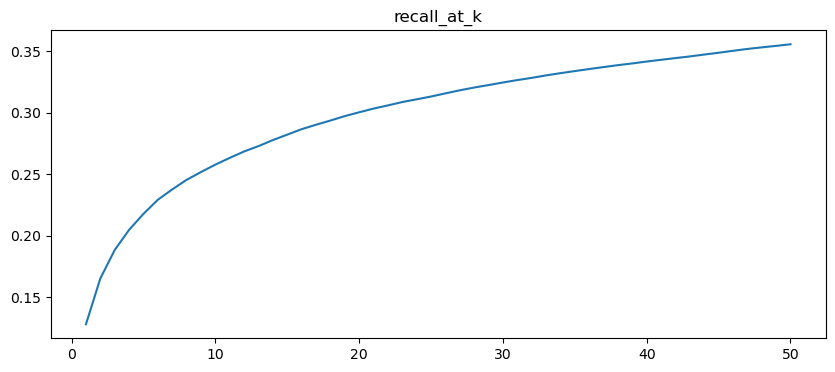

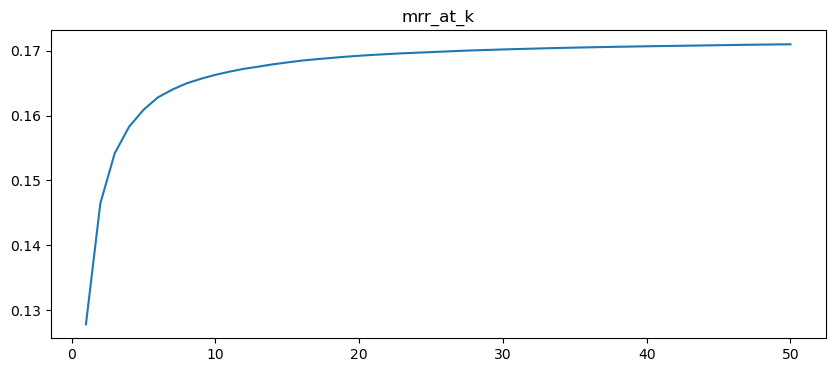

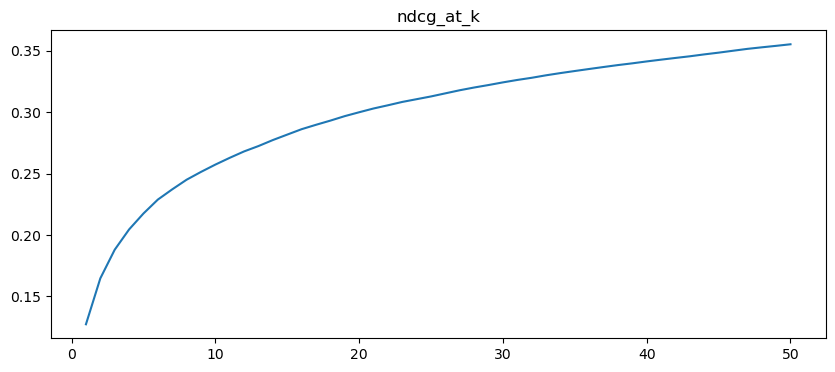

In [72]:
for func in [recall_at_k, mrr_at_k, ndcg_at_k]:
    y=[func(np.array(predictions), target_values, k=k) for k in range(1, 51)]
    x=range(1, 51)
    fig = plt.figure(figsize=(10, 4))
    plt.plot(x, y)
    plt.title(f'{func.__name__}')
    plt.show()

## The Whole Process With Hyper Parameter Tuning

In [45]:

# Define the objective function for Optuna
def objective(trial):

    df = (pd
            .read_csv(r'retailrocket_data\events.csv')
            .pipe(lambda df: df.assign(timestamp = pd.to_datetime(df['timestamp'] * 1000000)))
            .sort_values(['visitorid', 'timestamp'])
            .set_index(['visitorid', 'timestamp'])
            .pipe(lambda df: df.assign(itemid_shift = df.groupby(level=0, as_index=False)['itemid'].shift()))
            .reset_index()    
             # drop duplicates and videos with 0 watch duration
            .query("itemid_shift != itemid")
          )

    counts = df.visitorid.value_counts()
    max_limit = counts[counts<500].index.to_list()
    min_limit = counts[counts>5].index.to_list()

    df = (df
            .query('visitorid in @min_limit and visitorid in @max_limit')
            .rename(columns={'visitorid':'clientid', 'itemid':'item_id'})
            .astype(str)
          )[['clientid', 'item_id']]


    # group by user
    df_group = df.groupby("clientid")

    data = pd.DataFrame(
                         data={
                               "clientid": list(df_group.groups.keys()),
                               "item_id": list(df_group.item_id.apply(list)),
                               }
                        )

    # create a sequences with length of n for each user
    data.item_id = data.item_id.apply(lambda ids: create_sequences(ids, window_size=trial.suggest_int('window_size', 4, 20), step_size=1))

    # explode
    data_transformed = data[["clientid", "item_id"]].explode(["item_id"], ignore_index=True)

    # target is the last records (item) in the list  -> item seq:[4,5,6,7,8] item target:[9]
    # convert each variable to numpy array
    data_transformed['target'] = data_transformed['item_id'].apply(lambda x : np.array(x[-1], dtype=str))
    data_transformed['item_id'] = data_transformed['item_id'].apply(lambda x : np.array(x[:-1], dtype=str))
    data_transformed = data_transformed[['item_id', 'target']]

    # convert each variable to tensor and store in a dict then convert to tensorflow Dataset
    data_transformed = {
                        'item_id': tf.constant(data_transformed["item_id"].to_list(), name='item_id'),
                        'target': tf.constant(data_transformed["target"], name='target')
                       }

    tf_dict = tf.data.Dataset.from_tensor_slices(data_transformed)

    # map rows to a dictionary
    data = tf_dict.map(lambda x: {'item_id': x['item_id'],  'target': x['target']})
    items = tf.data.Dataset.from_tensor_slices({'item_id':df.item_id.unique()}).map(lambda x: x['item_id'])
    
    # Split the dataset to train validation and test
    cached_train, cached_validation, cached_test = train_validation_test_split(data, len(data_transformed['target']), 0.15, 0.15)

    # Train The model
    tf.keras.backend.clear_session()
    model = GRU4REC(items=items, 
                    embedding_dimension=trial.suggest_categorical('embedding_dimension', [32, 64, 128, 256, 512]),
                    dropout=trial.suggest_float('dropout', 0, 0.7, step=0.05), 
                    recurrent_dropout=trial.suggest_float('dropout', 0, 0.7, step=0.05)
                   )
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)))

    # Callbacks setting
    es = EarlyStopping(monitor='val_factorized_top_k/top_20_categorical_accuracy', min_delta=0.01, patience=3, verbose=1)
    mcp = ModelCheckpoint(filepath=r'gru_weights/weights{epoch:02d}.h5', monitor='val_factorized_top_k/top_20_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
    rlr = ReduceLROnPlateau(monitor='val_factorized_top_k/top_20_categorical_accuracy', factor=0.5, patience=1, min_lr=1e-7, verbose=1)

    history = model.fit(cached_train, batch_size=trial.suggest_categorical('batch_size', [32, 64, 128, 256, 256, 1024, 4096, 16384]),
                        epochs=30,
                        validation_data=cached_validation, 
                        callbacks=[es, mcp, rlr],
                        verbose=0)
    # Save and load the best model 
    list_of_files = glob.glob('gru_weights/*')
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)

    model.built = True
    model.load_weights(latest_file)

    for f in list_of_files:
        os.remove(f)
    # Metric to optimize: top 20 accuracy
    evaluate = model.evaluate(cached_test)

    return evaluate[0]

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=50)

# Get the best hyperparameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2023-12-06 16:49:22,757] A new study created in memory with name: no-name-c2284ca7-8f55-41d1-81a2-ce465c91887a



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03765, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03765 to 0.05184, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05184 to 0.06578, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06578 to 0.07573, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07573 to 0.08122, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08122 to 0.08665, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08665 to 0.08963, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 17:16:26,365] Trial 0 finished with value: 0.09729789942502975 and parameters: {'window_size': 7, 'embedding_dimension': 128, 'dropout': 0.2, 'learning_rate': 0.016124591095265373, 'batch_size': 32}. Best is trial 0 with value: 0.09729789942502975.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00030, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00030 to 0.00033, saving model to gru_weights\weights02.h5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00014937091327738017.

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00033 to 0.00040, saving model to gru_weights\weights03.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 7.468545663869008e-05.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00040 to 0.00043, saving model to gru_weights\weights04.h5
Epoch 4: early stopping
gru_weights\weights04.h5
8/8 [==============================] - 66s 8s/step - factorized_top_k/top_20_categorical_accuracy: 3.6615e-04 - loss: 28697.0955 - regularization_loss: 0.0000e+00 - total_loss: 28697.0955


[I 2023-12-06 17:26:17,926] Trial 1 finished with value: 0.0003661540395114571 and parameters: {'window_size': 12, 'embedding_dimension': 128, 'dropout': 0.05, 'learning_rate': 0.00029874182104867164, 'batch_size': 32}. Best is trial 0 with value: 0.09729789942502975.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00139, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00139 to 0.00468, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00468 to 0.00670, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00670 to 0.00990, saving model to gru_weights\weights04.h5
Epoch 4: early stopping
gru_weights\weights04.h5
6/6 [==============================] - 115s 19s/step - factorized_top_k/top_20_categorical_accuracy: 0.0107 - loss: 39709.9040 - regularization_loss: 0.0000e+00 - total_loss: 39709.9040


[I 2023-12-06 17:56:44,622] Trial 2 finished with value: 0.010662059299647808 and parameters: {'window_size': 17, 'embedding_dimension': 512, 'dropout': 0.30000000000000004, 'learning_rate': 0.04337743182470487, 'batch_size': 256}. Best is trial 0 with value: 0.09729789942502975.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.04807, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04807 to 0.11795, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11795 to 0.17453, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17453 to 0.20751, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.20751 to 0.22465, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.22465 to 0.23415, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23415 to 0.23957, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 18:22:35,289] Trial 3 finished with value: 0.2445949912071228 and parameters: {'window_size': 9, 'embedding_dimension': 128, 'dropout': 0.45, 'learning_rate': 0.04451347975435398, 'batch_size': 64}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00257, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00257 to 0.01001, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01001 to 0.01506, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01506 to 0.01588, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01588 to 0.01664, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01664

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0011173379607498646.
Epoch 6: early stopping
gru_weights\weights05.h5
9/9 [==============================] - 88s 10s/step - factorized_top_k/top_20_categorical_accuracy: 0.0178 - loss: 2911

[I 2023-12-06 18:37:22,255] Trial 4 finished with value: 0.01777583174407482 and parameters: {'window_size': 10, 'embedding_dimension': 128, 'dropout': 0.55, 'learning_rate': 0.0022346758408902253, 'batch_size': 256}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01686, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01686 to 0.03269, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03269 to 0.03820, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03820 to 0.04289, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04289 to 0.04792, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04792 to 0.05130, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05130 to 0.05540, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 18:54:04,095] Trial 5 finished with value: 0.06631839275360107 and parameters: {'window_size': 11, 'embedding_dimension': 64, 'dropout': 0.55, 'learning_rate': 0.021087639556375753, 'batch_size': 1024}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00014, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00014 to 0.00102, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00102 to 0.00211, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00211 to 0.00507, saving model to gru_weights\weights04.h5
Epoch 4: early stopping
gru_weights\weights04.h5
7/7 [==============================] - 50s 7s/step - factorized_top_k/top_20_categorical_accuracy: 0.0054 - loss: 33453.3237 - regularization_loss: 0.0000e+00 - total_loss: 33453.3237


[I 2023-12-06 18:59:38,454] Trial 6 finished with value: 0.00538599630817771 and parameters: {'window_size': 13, 'embedding_dimension': 32, 'dropout': 0.55, 'learning_rate': 0.001702328279090581, 'batch_size': 32}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00942, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00942 to 0.01767, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01767 to 0.01889, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01889

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0033502918668091297.
Epoch 4: early stopping
gru_weights\weights03.h5
8/8 [==============================] - 52s 6s/step - factorized_top_k/top_20_categorical_accuracy: 0.0191 - loss: 32031.0877 - regularization_loss: 0.0000e+00 - total_loss: 32031.0877


[I 2023-12-06 19:05:35,622] Trial 7 finished with value: 0.019050896167755127 and parameters: {'window_size': 11, 'embedding_dimension': 32, 'dropout': 0.65, 'learning_rate': 0.006700583949302325, 'batch_size': 64}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00032, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.00032

Epoch 2: ReduceLROnPlateau reducing learning rate to 1.7181253497255966e-05.

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00032 to 0.00033, saving model to gru_weights\weights03.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 8.590626748627983e-06.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.00033

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.2953133743139915e-06.
Epoch 4: early stopping
gru_weights\weights03.h5
14/14 [==============================] - 117s 8s/step - factorized_top_k/top_20_categorical_accuracy: 2.6436e-04 - loss: 33325.2586 - regularization_loss: 0.0000e+00 - total_loss: 33325.2586


[I 2023-12-06 19:21:12,219] Trial 8 finished with value: 0.0002643637708388269 and parameters: {'window_size': 5, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 3.436250562908517e-05, 'batch_size': 32}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00790, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00790 to 0.01590, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01590

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002344863722100854.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01590

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001172431861050427.
Epoch 4: early stopping
gru_weights\weights02.h5
14/14 [==============================] - 96s 7s/step - factorized_top_k/top_20_categorical_accuracy: 0.0173 - loss: 33285.3828 - regularization_loss: 0.0000e+00 - total_loss: 33285.3828


[I 2023-12-06 19:31:02,540] Trial 9 finished with value: 0.017307015135884285 and parameters: {'window_size': 5, 'embedding_dimension': 64, 'dropout': 0.7, 'learning_rate': 0.00468972767413828, 'batch_size': 1024}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01760, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01760 to 0.03308, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03308 to 0.08934, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08934 to 0.11391, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11391 to 0.13595, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13595 to 0.14319, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14319 to 0.14722, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 20:25:01,612] Trial 10 finished with value: 0.14740224182605743 and parameters: {'window_size': 19, 'embedding_dimension': 512, 'dropout': 0.4, 'learning_rate': 0.08624264297617684, 'batch_size': 128}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00365, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00365 to 0.00827, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00827 to 0.00967, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00967 to 0.01168, saving model to gru_weights\weights04.h5
Epoch 4: early stopping
gru_weights\weights04.h5
6/6 [==============================] - 66s 11s/step - factorized_top_k/top_20_categorical_accuracy: 0.0115 - loss: 83189.3259 - regularization_loss: 0.0000e+00 - total_loss: 83189.3259


[I 2023-12-06 20:47:41,331] Trial 11 finished with value: 0.011544213630259037 and parameters: {'window_size': 20, 'embedding_dimension': 512, 'dropout': 0.4, 'learning_rate': 0.07780885673807027, 'batch_size': 128}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00215, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00215 to 0.01065, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01065 to 0.01725, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01725 to 0.02949, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02949 to 0.04184, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04184 to 0.05946, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05946 to 0.06784, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 22:09:13,182] Trial 12 finished with value: 0.08679979294538498 and parameters: {'window_size': 16, 'embedding_dimension': 512, 'dropout': 0.4, 'learning_rate': 0.07186013665886604, 'batch_size': 64}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03718, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03718 to 0.06791, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06791 to 0.09939, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.09939 to 0.14091, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14091 to 0.16476, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16476 to 0.18033, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.18033 to 0.18641, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 22:35:36,345] Trial 13 finished with value: 0.19462822377681732 and parameters: {'window_size': 8, 'embedding_dimension': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.09572562802609598, 'batch_size': 128}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.02809, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02809 to 0.06199, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06199 to 0.09099, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.09099 to 0.11462, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11462 to 0.13212, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13212 to 0.14516, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14516 to 0.15281, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 23:14:02,955] Trial 14 finished with value: 0.18549422919750214 and parameters: {'window_size': 8, 'embedding_dimension': 256, 'dropout': 0.25, 'learning_rate': 0.018441981947679622, 'batch_size': 4096}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01170, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01170 to 0.03134, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03134 to 0.04270, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04270 to 0.05075, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05075 to 0.05753, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05753 to 0.06140, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06140 to 0.06598, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-06 23:44:23,614] Trial 15 finished with value: 0.07365728914737701 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.15000000000000002, 'learning_rate': 0.00818227119278255, 'batch_size': 16384}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03960, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03960 to 0.06961, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06961 to 0.09577, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.09577 to 0.11941, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11941 to 0.13528, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13528 to 0.14457, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14457 to 0.15326, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 00:05:53,691] Trial 16 finished with value: 0.1705579161643982 and parameters: {'window_size': 9, 'embedding_dimension': 128, 'dropout': 0.45, 'learning_rate': 0.028615614142548842, 'batch_size': 256}. Best is trial 3 with value: 0.2445949912071228.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.17117, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17117 to 0.23917, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23917 to 0.25089, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25089 to 0.26763, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26763 to 0.27167, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27167 to 0.27306, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27306 to 0.27424, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
16/16 [=========

[I 2023-12-07 00:29:42,984] Trial 17 finished with value: 0.2700389623641968 and parameters: {'window_size': 4, 'embedding_dimension': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.08748744601208104, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.00029, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00029 to 0.00032, saving model to gru_weights\weights02.h5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002300897758686915.

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00032 to 0.00034, saving model to gru_weights\weights03.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00011504488793434575.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.00034 to 0.00035, saving model to gru_weights\weights04.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.7522443967172876e-05.
Epoch 4: early stopping
gru_weights\weights04.h5
16/16 [==============================] - 108s 7s/step - factorized_top_k/top_20_categorical_accuracy: 3.5128e-04 - loss: 31050.1298 - regularization_loss: 0.0000e+00 - total_loss: 31050

[I 2023-12-07 00:41:26,099] Trial 18 finished with value: 0.00035128058516420424 and parameters: {'window_size': 4, 'embedding_dimension': 128, 'dropout': 0.5, 'learning_rate': 0.00046017956058435884, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.02522, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02522 to 0.05762, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05762 to 0.08518, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08518 to 0.10895, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10895 to 0.13450, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13450 to 0.15424, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15424 to 0.16857, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 01:10:59,071] Trial 19 finished with value: 0.19934822618961334 and parameters: {'window_size': 14, 'embedding_dimension': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.0262494124486439, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01786, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01786

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.004504784941673279.

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01786

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0022523924708366394.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01786

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0011261962354183197.
Epoch 4: early stopping
gru_weights\weights01.h5
13/13 [==============================] - 77s 6s/step - factorized_top_k/top_20_categorical_accuracy: 0.0166 - loss: 30862.4601 - regularization_loss: 0.0000e+00 - total_loss: 30862.4601


[I 2023-12-07 01:19:08,841] Trial 20 finished with value: 0.016597183421254158 and parameters: {'window_size': 6, 'embedding_dimension': 64, 'dropout': 0.65, 'learning_rate': 0.00900957005566355, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03470, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03470 to 0.08488, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08488 to 0.12906, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.12906 to 0.15998, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15998 to 0.17854, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17854 to 0.19065, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.19065 to 0.20324, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 01:49:51,864] Trial 21 finished with value: 0.21656852960586548 and parameters: {'window_size': 14, 'embedding_dimension': 256, 'dropout': 0.30000000000000004, 'learning_rate': 0.031529149228342095, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03903, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03903 to 0.09010, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.09010 to 0.14298, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14298 to 0.17850, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17850 to 0.20057, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.20057 to 0.21527, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21527 to 0.22305, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 02:17:59,994] Trial 22 finished with value: 0.2274562120437622 and parameters: {'window_size': 14, 'embedding_dimension': 256, 'dropout': 0.2, 'learning_rate': 0.039100415252113774, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03204, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03204 to 0.07307, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07307 to 0.10227, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10227 to 0.13686, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13686 to 0.15412, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15412 to 0.17376, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17376 to 0.18186, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 02:45:57,684] Trial 23 finished with value: 0.1972133368253708 and parameters: {'window_size': 16, 'embedding_dimension': 256, 'dropout': 0.0, 'learning_rate': 0.03363070305334428, 'batch_size': 256}. Best is trial 17 with value: 0.2700389623641968.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.16635, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16635 to 0.24018, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24018 to 0.24936, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24936 to 0.26825, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26825 to 0.27087, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27087 to 0.27331, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27331 to 0.27346, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
16/16 [=========

[I 2023-12-07 03:10:19,258] Trial 24 finished with value: 0.2700549364089966 and parameters: {'window_size': 4, 'embedding_dimension': 256, 'dropout': 0.2, 'learning_rate': 0.049772857853953335, 'batch_size': 64}. Best is trial 24 with value: 0.2700549364089966.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01632, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01632

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0060929046012461185.

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01632

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0030464523006230593.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01632

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0015232261503115296.
Epoch 4: early stopping
gru_weights\weights01.h5
16/16 [==============================] - 93s 6s/step - factorized_top_k/top_20_categorical_accuracy: 0.0163 - loss: 30864.6017 - regularization_loss: 0.0000e+00 - total_loss: 30864.6017


[I 2023-12-07 03:21:05,172] Trial 25 finished with value: 0.016318580135703087 and parameters: {'window_size': 4, 'embedding_dimension': 32, 'dropout': 0.2, 'learning_rate': 0.012185809661803701, 'batch_size': 256}. Best is trial 24 with value: 0.2700549364089966.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.10120, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10120 to 0.17972, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17972 to 0.22453, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.22453 to 0.24398, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24398 to 0.25324, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25324 to 0.26105, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26105 to 0.26581, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 03:41:06,981] Trial 26 finished with value: 0.2721623480319977 and parameters: {'window_size': 6, 'embedding_dimension': 128, 'dropout': 0.35000000000000003, 'learning_rate': 0.05867287609888114, 'batch_size': 64}. Best is trial 26 with value: 0.2721623480319977.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.17107, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17107 to 0.24878, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24878 to 0.28642, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28642 to 0.30203, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.30203 to 0.30679, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.30679 to 0.30888, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.30888 to 0.30970, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
13/13 [=========

[I 2023-12-07 04:03:01,685] Trial 27 finished with value: 0.3074805438518524 and parameters: {'window_size': 6, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.09409465936263611, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03019, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03019 to 0.04885, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04885 to 0.06904, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06904 to 0.08560, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08560 to 0.09541, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.09541 to 0.10358, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10358 to 0.10969, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 04:44:25,248] Trial 28 finished with value: 0.13555023074150085 and parameters: {'window_size': 6, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.01331797507431468, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01647, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01647 to 0.04137, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04137 to 0.06098, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06098 to 0.07147, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07147 to 0.07747, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07747 to 0.08507, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08507 to 0.08949, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 05:01:36,877] Trial 29 finished with value: 0.09427767246961594 and parameters: {'window_size': 8, 'embedding_dimension': 128, 'dropout': 0.0, 'learning_rate': 0.016547085013397276, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01117, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01117 to 0.01508, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01508

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.002096988493576646.

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.01508

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001048494246788323.
Epoch 4: early stopping
gru_weights\weights02.h5
13/13 [==============================] - 83s 6s/step - factorized_top_k/top_20_categorical_accuracy: 0.0146 - loss: 30822.6233 - regularization_loss: 0.0000e+00 - total_loss: 30822.6233


[I 2023-12-07 05:11:19,938] Trial 30 finished with value: 0.014611028134822845 and parameters: {'window_size': 6, 'embedding_dimension': 128, 'dropout': 0.15000000000000002, 'learning_rate': 0.004193976907936342, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.17827, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17827 to 0.24171, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24171 to 0.25358, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25358 to 0.26827, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26827 to 0.27165, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27165 to 0.27432, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy did not improve from 0.27432

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.02635345794260502.
Epoch 7: early stopping
gru_weights\

[I 2023-12-07 05:35:18,618] Trial 31 finished with value: 0.27144408226013184 and parameters: {'window_size': 4, 'embedding_dimension': 256, 'dropout': 0.25, 'learning_rate': 0.05270691688705825, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.15347, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15347 to 0.24200, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24200 to 0.25501, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25501 to 0.28216, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28216 to 0.28583, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28583 to 0.28814, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28814 to 0.28856, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
14/14 [=========

[I 2023-12-07 05:58:48,252] Trial 32 finished with value: 0.28390905261039734 and parameters: {'window_size': 5, 'embedding_dimension': 256, 'dropout': 0.15000000000000002, 'learning_rate': 0.06523692448088197, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.06734, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06734 to 0.16262, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16262 to 0.20451, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.20451 to 0.24197, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24197 to 0.25902, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25902 to 0.26819, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26819 to 0.27601, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 06:26:53,141] Trial 33 finished with value: 0.2806849777698517 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.04787260456427912, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.11796, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11796 to 0.21245, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21245 to 0.24866, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24866 to 0.27764, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27764 to 0.28633, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28633 to 0.29025, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.29025 to 0.29051, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 06:52:18,591] Trial 34 finished with value: 0.28902480006217957 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.05, 'learning_rate': 0.09918895965149119, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.02969, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02969 to 0.08024, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08024 to 0.14000, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14000 to 0.19133, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.19133 to 0.21732, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21732 to 0.23240, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23240 to 0.23990, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 07:23:02,699] Trial 35 finished with value: 0.2457689344882965 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.05, 'learning_rate': 0.09514388917353493, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.08208, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08208 to 0.16764, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16764 to 0.21687, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21687 to 0.24781, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.24781 to 0.25928, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25928 to 0.26597, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26597 to 0.26927, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 07:52:31,099] Trial 36 finished with value: 0.2722610533237457 and parameters: {'window_size': 9, 'embedding_dimension': 256, 'dropout': 0.05, 'learning_rate': 0.043180041386325634, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03222, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03222 to 0.05432, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05432 to 0.07790, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07790 to 0.11559, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11559 to 0.14031, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.14031 to 0.15896, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15896 to 0.16915, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 08:26:47,384] Trial 37 finished with value: 0.20796847343444824 and parameters: {'window_size': 10, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.02119336158876659, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.15820, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15820 to 0.23454, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23454 to 0.25589, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25589 to 0.27875, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.27875 to 0.28335, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28335 to 0.28745, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28745 to 0.28793, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
14/14 [=========

[I 2023-12-07 08:49:36,839] Trial 38 finished with value: 0.28367993235588074 and parameters: {'window_size': 5, 'embedding_dimension': 256, 'dropout': 0.15000000000000002, 'learning_rate': 0.04860160098819423, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.01458, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.01458 to 0.02800, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02800 to 0.03493, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03493 to 0.04219, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04219 to 0.04727, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04727 to 0.05226, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05226 to 0.05661, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 09:09:48,131] Trial 39 finished with value: 0.062266480177640915 and parameters: {'window_size': 5, 'embedding_dimension': 32, 'dropout': 0.15000000000000002, 'learning_rate': 0.025389384930428888, 'batch_size': 4096}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.06956, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06956 to 0.12020, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.12020 to 0.15696, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15696 to 0.17741, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17741 to 0.19140, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.19140 to 0.19975, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.19975 to 0.20430, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 09:34:33,348] Trial 40 finished with value: 0.20500528812408447 and parameters: {'window_size': 5, 'embedding_dimension': 64, 'dropout': 0.05, 'learning_rate': 0.05663098829186866, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.04388, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04388 to 0.11705, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11705 to 0.16873, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16873 to 0.20838, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.20838 to 0.22735, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.22735 to 0.23899, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23899 to 0.24548, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 10:04:08,582] Trial 41 finished with value: 0.2488602250814438 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.047600488259356866, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.07835, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07835 to 0.17367, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17367 to 0.21686, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21686 to 0.25346, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25346 to 0.26269, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26269 to 0.26957, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26957 to 0.27210, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 10:35:53,636] Trial 42 finished with value: 0.2714778184890747 and parameters: {'window_size': 7, 'embedding_dimension': 256, 'dropout': 0.0, 'learning_rate': 0.09674029488386075, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.10245, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10245 to 0.17529, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.17529 to 0.20196, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.20196 to 0.22011, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.22011 to 0.23183, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23183 to 0.23750, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23750 to 0.24221, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 11:09:57,474] Trial 43 finished with value: 0.245858296751976 and parameters: {'window_size': 5, 'embedding_dimension': 256, 'dropout': 0.15000000000000002, 'learning_rate': 0.031241644878902044, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.05150, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05150 to 0.12640, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.12640 to 0.16659, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.16659 to 0.21480, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.21480 to 0.23771, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.23771 to 0.25072, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.25072 to 0.25706, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 11:35:34,981] Trial 44 finished with value: 0.2590353190898895 and parameters: {'window_size': 9, 'embedding_dimension': 256, 'dropout': 0.1, 'learning_rate': 0.05953931504574247, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.02490, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.02490 to 0.04911, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04911 to 0.07730, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07730 to 0.11096, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11096 to 0.13736, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.13736 to 0.15482, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.15482 to 0.17211, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 12:46:44,996] Trial 45 finished with value: 0.21159321069717407 and parameters: {'window_size': 11, 'embedding_dimension': 512, 'dropout': 0.05, 'learning_rate': 0.016616070598016213, 'batch_size': 256}. Best is trial 27 with value: 0.3074805438518524.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.18029, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.18029 to 0.26288, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26288 to 0.28280, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28280 to 0.30719, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.30719 to 0.31259, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.31259 to 0.31505, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.31505 to 0.31617, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
13/13 [=========

[I 2023-12-07 13:09:12,130] Trial 46 finished with value: 0.316192090511322 and parameters: {'window_size': 6, 'embedding_dimension': 256, 'dropout': 0.25, 'learning_rate': 0.06258085768442055, 'batch_size': 256}. Best is trial 46 with value: 0.316192090511322.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.04727, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04727 to 0.07103, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.07103 to 0.08784, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.08784 to 0.10275, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.10275 to 0.11606, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.11606 to 0.12444, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.12444 to 0.13427, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 13:36:02,478] Trial 47 finished with value: 0.16382835805416107 and parameters: {'window_size': 6, 'embedding_dimension': 32, 'dropout': 0.25, 'learning_rate': 0.0661464695454943, 'batch_size': 256}. Best is trial 46 with value: 0.316192090511322.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.03231, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.03231 to 0.04360, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.04360 to 0.05034, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05034 to 0.05791, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.05791 to 0.06093, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06093 to 0.06663, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.06663 to 0.06853, saving model to gru_weights\weights07.h5

Epoch 8: val_factorized_top_k/top_20_categorical_accuracy improv

[I 2023-12-07 13:51:11,326] Trial 48 finished with value: 0.07596030086278915 and parameters: {'window_size': 8, 'embedding_dimension': 64, 'dropout': 0.2, 'learning_rate': 0.02217262658073085, 'batch_size': 256}. Best is trial 46 with value: 0.316192090511322.



Epoch 1: val_factorized_top_k/top_20_categorical_accuracy improved from -inf to 0.18717, saving model to gru_weights\weights01.h5

Epoch 2: val_factorized_top_k/top_20_categorical_accuracy improved from 0.18717 to 0.26139, saving model to gru_weights\weights02.h5

Epoch 3: val_factorized_top_k/top_20_categorical_accuracy improved from 0.26139 to 0.28239, saving model to gru_weights\weights03.h5

Epoch 4: val_factorized_top_k/top_20_categorical_accuracy improved from 0.28239 to 0.29336, saving model to gru_weights\weights04.h5

Epoch 5: val_factorized_top_k/top_20_categorical_accuracy improved from 0.29336 to 0.29685, saving model to gru_weights\weights05.h5

Epoch 6: val_factorized_top_k/top_20_categorical_accuracy improved from 0.29685 to 0.29822, saving model to gru_weights\weights06.h5

Epoch 7: val_factorized_top_k/top_20_categorical_accuracy improved from 0.29822 to 0.29891, saving model to gru_weights\weights07.h5
Epoch 7: early stopping
gru_weights\weights07.h5
14/14 [=========

[I 2023-12-07 14:14:29,691] Trial 49 finished with value: 0.2947655916213989 and parameters: {'window_size': 5, 'embedding_dimension': 256, 'dropout': 0.15000000000000002, 'learning_rate': 0.09612145478087826, 'batch_size': 256}. Best is trial 46 with value: 0.316192090511322.


Best Hyperparameters: {'window_size': 6, 'embedding_dimension': 256, 'dropout': 0.25, 'learning_rate': 0.06258085768442055, 'batch_size': 256}


In [47]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_embedding_dimension,params_learning_rate,params_window_size,state
0,0,0.097298,2023-12-06 16:49:22.759134,2023-12-06 17:16:26.362385,0 days 00:27:03.603251,32,0.20,128,0.016125,7,COMPLETE
1,1,0.000366,2023-12-06 17:16:26.367383,2023-12-06 17:26:17.915312,0 days 00:09:51.547929,32,0.05,128,0.000299,12,COMPLETE
2,2,0.010662,2023-12-06 17:26:17.965282,2023-12-06 17:56:44.608557,0 days 00:30:26.643275,256,0.30,512,0.043377,17,COMPLETE
3,3,0.244595,2023-12-06 17:56:44.634541,2023-12-06 18:22:35.287596,0 days 00:25:50.653055,64,0.45,128,0.044513,9,COMPLETE
4,4,0.017776,2023-12-06 18:22:35.292590,2023-12-06 18:37:22.253953,0 days 00:14:46.961363,256,0.55,128,0.002235,10,COMPLETE
5,5,0.066318,2023-12-06 18:37:22.257952,2023-12-06 18:54:04.093634,0 days 00:16:41.835682,1024,0.55,64,0.021088,11,COMPLETE
6,6,0.005386,2023-12-06 18:54:04.100631,2023-12-06 18:59:38.453849,0 days 00:05:34.353218,32,0.55,32,0.001702,13,COMPLETE
7,7,0.019051,2023-12-06 18:59:38.455849,2023-12-06 19:05:35.622150,0 days 00:05:57.166301,64,0.65,32,0.006701,11,COMPLETE
8,8,0.000264,2023-12-06 19:05:35.624148,2023-12-06 19:21:12.219610,0 days 00:15:36.595462,32,0.10,256,0.000034,5,COMPLETE
9,9,0.017307,2023-12-06 19:21:12.222607,2023-12-06 19:31:02.540177,0 days 00:09:50.317570,1024,0.70,64,0.004690,5,COMPLETE
